In [9]:
# Re-run this cell whenever parser.py is changed
import importlib
importlib.reload(parser)

<module 'parser' from '/Users/ivanprigarin/Library/Mobile Documents/com~apple~CloudDocs/cloud-files/1_study/cluster/code/mln-project/tool/parser.py'>

In [8]:
import parser
from pprint import pprint

In [10]:
mln_data = parser.parse_mln('network.txt')
pprint(mln_data)

Parsing network configuration file network.txt
{'actors': (['3', '1', '2'], 3),
 'edges': ({'dir': [False, False, False, False, False],
            'from_actor': ['1', '1', '2', '1', '1'],
            'from_layer': ['2', '2', '2', '1', '1'],
            'to_actor': ['2', '3', '3', '2', '3'],
            'to_layer': ['2', '2', '2', '1', '1']},
           [[('1', '2'),
             ('2', '1'),
             ('1', '3'),
             ('3', '1'),
             ('2', '3'),
             ('3', '2')],
            [('1', '2'), ('2', '1'), ('1', '3'), ('3', '1')]]),
 'layers': (['2', '1'], 2)}


In [11]:
language = parser.parse_language_file('toy-example.mln')
pprint(language)

Parsing MLN language file toy-example.mln
{'initial conditions': ['1 = AI', '2 = US', '3 = US'],
 'parameters': ['delta = 1', 'mu = 1', 'betaA = 1', 'betaU = 3', 'lamb = 1'],
 'rules': ['AS -> US @ delta',
           'AI -> AS @ mu',
           'AS =1 AI -> AI =1 AI @ betaA',
           'US =1 AI -> AI =1 AI @ betaU',
           'US =2 AI -> AS =2 AI @ lamb',
           'US =2 AS -> AS =2 AS @ lamb'],
 'simOptions': ['n = 1000', 't = 30'],
 'states': ['AS', 'AI', 'US'],
 'views': ['AI', 'AS', 'US']}


In [130]:
def parse_signatures(mln_data, language):
    signatures = ['/* Signatures */']
    
    states = []
    for state in language['states']:
        states.append(state)
    states = '{' + ', '.join(states) + '}'

    for i, actor in enumerate(mln_data['actors'][0]):
        sites = []
        for j, layer in enumerate(mln_data['edges'][1]):
            for edge in layer:
                if edge[0] == str(i+1):
                    sites.append(f'l{j+1}v{edge[1]}')
        sites = ', '.join(sites)
                                 
        kappa_signature = f'%agent: V{i+1}(state{states}, {sites})'
        signatures.append(kappa_signature)
        
        
    signatures = '\n'.join(signatures)
    
    return signatures

In [131]:
print(parse_signatures(mln_data, language))

/* Signatures */
%agent: V1(state{AS, AI, US}, l1v2, l1v3, l2v2, l2v3)
%agent: V2(state{AS, AI, US}, l1v1, l2v1, l2v3)
%agent: V3(state{AS, AI, US}, l1v1, l2v1, l2v2)


In [31]:
def parse_variables(language):
    variables = ['/* Variables */']
    
    for param in language['parameters']:
        var_name, var_value = param.split('=')
        var = f"%var: '{var_name.strip()}' {var_value.strip()}"
        variables.append(var)
    variables = '\n'.join(variables)
    
    return variables

In [32]:
print(parse_variables(language))

/* Variables */
%var: 'delta' 1
%var: 'mu' 1
%var: 'betaA' 1
%var: 'betaU' 3
%var: 'lamb' 1


In [36]:
def parse_observables(mln_data, language):
    observables = ['/* Observables */']
    
    for view in language['views']:
        components = []
        for i, actor in enumerate(mln_data['actors'][0]):
            components.append(f'|V{i+1}(state{{{view}}})|')
        obs = f"%obs: '{view}' " + ' + '.join(components)
        observables.append(obs)
    
    observables = '\n'.join(observables)
    
    return observables

In [37]:
print(parse_observables(mln_data, language))

/* Observables */
%obs: 'AI' |V1(state{AI})| + |V2(state{AI})| + |V3(state{AI})|
%obs: 'AS' |V1(state{AS})| + |V2(state{AS})| + |V3(state{AS})|
%obs: 'US' |V1(state{US})| + |V2(state{US})| + |V3(state{US})|


In [64]:
def parse_initial_conditions(mln_data, language):
    n = ''
    for line in language['simOptions']:
        option, value = line.split('=')
        if option.strip() == 'n':
            n = value.strip()
            break
            
    i_c = ['/* Initial conditions */',
           f'%init: {n} (']
    
    initial_states = [x.split('=') for x in language['initial conditions']]

    for i, actor in enumerate(mln_data['actors'][0]):
        sites = []
        site_labels = []
        for j, layer in enumerate(mln_data['edges'][1]):
            for edge in layer:
                if edge[0] == str(i+1):
                    # weird way to keep site labels consistent.
                    # will need a rewrite
                    if i+1 <= int(edge[1]):
                        site_label = f'{j+1}{i+1}{edge[1]}'
                    else:
                        site_label = f'{j+1}{edge[1]}{i+1}'
                        
                    sites.append(f'l{j+1}v{edge[1]}[{site_label}]')
        sites = ', '.join(sites)
        
        initial_state = ''
        for state in initial_states:
            if state[0].strip() == str(i+1):
                initial_state = state[1].strip()
                
        condition = f'V{i+1}(state{{{initial_state}}}, {sites})'
        
        # add a comma unless it's the last entry
        if i + 1 < int(mln_data['actors'][1]):
            condition += ','
        
        i_c.append(condition)
    
    i_c.append(')')
        
    i_c = '\n'.join(i_c)
    
    return i_c

In [65]:
print(parse_initial_conditions(mln_data, language))

/* Initial conditions */
%init: 1000 (
V1(state{AI}, l1v2[112], l1v3[113], l2v2[212], l2v3[213]),
V2(state{US}, l1v1[112], l2v1[212], l2v3[223]),
V3(state{US}, l1v1[113], l2v1[213], l2v2[223])
)


In [121]:
def parse_rules(mln_data, language):
    kappa_rules = ['/* Rules */']
    
    rules = [x.split('@') for x in language['rules']]
    rules_organised = []
    for ruleset in rules:
        rules_organised.append({'rule': ruleset[0].strip(), 'rate': ruleset[1].strip()})

    for ruleset in rules_organised:
        if '=' not in ruleset['rule']:
            # parse rules not dependant on layers
            rule_states = [state.strip() for state in ruleset['rule'].split('->')]
            kappa_rules.append(f"'{rule_states[0]} to {rule_states[1]}'")
            for i, actor in enumerate(mln_data['actors'][0]):
                kappa_rule = f"V{i+1}(state{{{rule_states[0]}}}) -> V{i+1}(state{{{rule_states[1]}}}) @ '{ruleset['rate']}'"
                kappa_rules.append(kappa_rule)
        else:
            # parse intra-layer rules
            # requires rules in both directions
            rule_sides = [state.strip() for state in ruleset['rule'].split('->')]
            layer = rule_sides[0][rule_sides[0].index('=')+1].strip()

            states = [[x[0].strip(), x[1].strip()] for x in [rule_side.split(f'={layer}') for rule_side in rule_sides]]
            kappa_rules.append(f"'{layer}: {states[0][0]}-{states[0][1]} to {states[1][0]}-{states[1][1]}'")
            for edge in mln_data['edges'][1][int(layer)-1]:
                v1, v2 = edge[0], edge[1]
                kappa_rules.append(f"// V{v1} - V{v2}")
                site_label = f'{layer}{v1}{v2}'
                kappa_rule = (f'V{v1}(state{{{states[0][0]}}}, l{layer}v{v2}[{site_label}]), V{v2}(state{{{states[0][1]}}}, l{layer}v{v1}[{site_label}]) -> '
                    f'V{v1}(state{{{states[1][0]}}}, l{layer}v{v2}[{site_label}]), V{v2}(state{{{states[1][1]}}}, l{layer}v{v1}[{site_label}]) @ '
                    f"'{ruleset['rate']}'")

                kappa_rules.append(kappa_rule)

        kappa_rules.append('')

    kappa_rules = '\n'.join(kappa_rules)

    return kappa_rules

In [122]:
print(parse_rules(mln_data, language))

/* Rules */
'AS to US'
V1(state{AS}) -> V1(state{US}) @ 'delta'
V2(state{AS}) -> V2(state{US}) @ 'delta'
V3(state{AS}) -> V3(state{US}) @ 'delta'

'AI to AS'
V1(state{AI}) -> V1(state{AS}) @ 'mu'
V2(state{AI}) -> V2(state{AS}) @ 'mu'
V3(state{AI}) -> V3(state{AS}) @ 'mu'

'1: AS-AI to AI-AI'
// V1 - V2
V1(state{AS}, l1v2[112]), V2(state{AI}, l1v1[112]) -> V1(state{AI}, l1v2[112]), V2(state{AI}, l1v1[112]) @ 'betaA'
// V2 - V1
V2(state{AS}, l1v1[121]), V1(state{AI}, l1v2[121]) -> V2(state{AI}, l1v1[121]), V1(state{AI}, l1v2[121]) @ 'betaA'
// V1 - V3
V1(state{AS}, l1v3[113]), V3(state{AI}, l1v1[113]) -> V1(state{AI}, l1v3[113]), V3(state{AI}, l1v1[113]) @ 'betaA'
// V3 - V1
V3(state{AS}, l1v1[131]), V1(state{AI}, l1v3[131]) -> V3(state{AI}, l1v1[131]), V1(state{AI}, l1v3[131]) @ 'betaA'

'1: US-AI to AI-AI'
// V1 - V2
V1(state{US}, l1v2[112]), V2(state{AI}, l1v1[112]) -> V1(state{AI}, l1v2[112]), V2(state{AI}, l1v1[112]) @ 'betaU'
// V2 - V1
V2(state{US}, l1v1[121]), V1(state{AI}, l1v2[

In [136]:
parser.parse_to_kappa('network.txt', 'toy-example.mln', 'out-kappa.txt')

Parsing network configuration file network.txt
Parsing MLN language file toy-example.mln
Successfully exported model into Kappa: out-kappa.txt


In [4]:
mln_data_4 = parser.parse_mln('network-four-nodes.txt')
language_4 = parser.parse_language_file('toy-example-four-nodes.mln')

Parsing network configuration file network-four-nodes.txt
Parsing MLN language file toy-example-four-nodes.mln


In [5]:
pprint(mln_data_4)

{'actors': (['1', '2', '3', '4'], 4),
 'edges': ({'dir': [False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False],
            'from_actor': ['1', '1', '1', '1', '1', '1', '2', '2', '3'],
            'from_layer': ['1', '1', '1', '2', '2', '2', '2', '2', '2'],
            'to_actor': ['2', '3', '4', '2', '3', '4', '3', '4', '4'],
            'to_layer': ['1', '1', '1', '2', '2', '2', '2', '2', '2']},
           [[('1', '2'),
             ('2', '1'),
             ('1', '3'),
             ('3', '1'),
             ('1', '4'),
             ('4', '1')],
            [('1', '2'),
             ('2', '1'),
             ('1', '3'),
             ('3', '1'),
             ('1', '4'),
             ('4', '1'),
             ('2', '3'),
             ('3', '2'),
             ('2', '4'),
             ('4', '2'),
             ('3', '4'),
   

In [6]:
pprint(language_4)

{'initial conditions': ['1 = AI', '2 = US', '3 = US', '4 = US'],
 'parameters': ['delta = 1', 'mu = 1', 'betaA = 1', 'betaU = 3', 'lamb = 1'],
 'rules': ['AS -> US @ delta',
           'AI -> AS @ mu',
           'AS =1 AI -> AI =1 AI @ betaA',
           'US =1 AI -> AI =1 AI @ betaU',
           'US =2 AI -> AS =2 AI @ lamb',
           'US =2 AS -> AS =2 AS @ lamb'],
 'simOptions': ['n = 1000', 't = 80'],
 'states': ['AS', 'AI', 'US'],
 'views': ['AI', 'AS', 'US']}


In [11]:
print(parser.parse_signatures(mln_data_4, language_4))

/* Signatures */
%agent: V1(state{AS, AI, US}, l1v2, l1v3, l1v4, l2v2, l2v3, l2v4)
%agent: V2(state{AS, AI, US}, l1v1, l2v1, l2v3, l2v4)
%agent: V3(state{AS, AI, US}, l1v1, l2v1, l2v2, l2v4)
%agent: V4(state{AS, AI, US}, l1v1, l2v1, l2v2, l2v3)


In [33]:
pprint(mln_data)

{'actors': (['1', '2', '3'], 3),
 'edges': ({'dir': [False, False, False, False, False],
            'from_actor': ['1', '1', '1', '1', '2'],
            'from_layer': ['1', '1', '2', '2', '2'],
            'to_actor': ['2', '3', '2', '3', '3'],
            'to_layer': ['1', '1', '2', '2', '2']},
           [[('1', '2'), ('2', '1'), ('1', '3'), ('3', '1')],
            [('1', '2'),
             ('2', '1'),
             ('1', '3'),
             ('3', '1'),
             ('2', '3'),
             ('3', '2')]]),
 'layers': (['1', '2'], 2)}


In [12]:
pprint(language)

{'initial conditions': ['1 = AI', '2 = US', '3 = US'],
 'parameters': ['delta = 1', 'mu = 1', 'betaA = 1', 'betaU = 3', 'lamb = 1'],
 'rules': ['AS -> US @ delta',
           'AI -> AS @ mu',
           'AS =1 AI -> AI =1 AI @ betaA',
           'US =1 AI -> AI =1 AI @ betaU',
           'US =2 AI -> AS =2 AI @ lamb',
           'US =2 AS -> AS =2 AS @ lamb'],
 'simOptions': ['n = 1000', 't = 30'],
 'states': ['AS', 'AI', 'US'],
 'views': ['AI', 'AS', 'US']}


In [59]:
def parse_to_gillespy(network_filename, language_filename, out_filename):
    mln_data = parser.parse_mln(network_filename)
    language = parser.parse_language_file(language_filename)

    tab = '\t'

    header_string = (
        f'import numpy\n'
        f'import matplotlib.pyplot as plt\n'
        f'from gillespy2.core import (\n'
        f'{tab}Model,\n'
        f'{tab}Species,\n'
        f'{tab}Reaction,\n'
        f'{tab}Parameter)\n\n'
        f'class Mln_dynamics(Model):\n'
        f'{tab}def __init__(self,parameter_values=None):\n'
        f'{tab * 2}Model.__init__(self, name="MLN")\n\n'
    )
    
    params = gillespie_parse_parameters(language)
    species = gillespie_parse_species(mln_data, language)
    reactions = gillespie_parse_reactions(mln_data, language)
    timespan = gillespie_parse_timespan(mln_data, language)
    footer = gillespie_parse_sim_options(mln_data, language)
    
    result = (
        header_string +
        params + '\n' +
        species + '\n' +
        reactions + '\n' +
        timespan + '\n' +
        footer
    )
    
    with open(out_filename, 'w') as f:
        f.write(result)
    
    return result


def gillespie_parse_parameters(language):
    tab = '\t'
    params = []
    param_names = []
    
    for param in language['parameters']:
        name, value = param.split('=')
        param_names.append(name.strip())
        params.append(f"{tab}{tab}{name.strip()} = Parameter(name='{name}', expression={value})")
    
    params.append(f"{tab}{tab}self.add_parameter([{', '.join(param_names)}])\n")
    params = '\n'.join(params)
    
    return params


def gillespie_parse_species(mln_data, language):
    tab = '\t'
    species = []
    species_names = []
    
    for state in language['states']:
        for actor in mln_data['actors'][0]:
            species_names.append(f"{state}{actor}")
            init_value = 0
            for init_conditions in language['initial conditions']:
                name, value = init_conditions.split('=')
                if actor == name.strip() and state == value.strip():
                    init_value = 1
                    break
            species.append(f"{tab}{tab}{state}{actor} = Species(name='{state}{actor}', initial_value={init_value})")
    
    species.append(f"{tab}{tab}self.add_species([{', '.join(species_names)}])\n")
    species = '\n'.join(species)
    
    return species


def gillespie_parse_reactions(mln_data, language):
    tab = '\t'
    reactions = []
    reaction_names = []
    counter = 0
    
    for rule in language['rules']:
        nodes, rate = rule.split('@')
        rate = rate.strip()
        
        if '=' not in nodes:
            # a simple state-to-state rule for a single node
            left_node, right_node = nodes.split('->')
            left_node = left_node.strip()
            right_node = right_node.strip()
            
            for i in range(1, mln_data['actors'][1] + 1):
                name = f"{left_node}{i}_to_{right_node}{i}_{counter}"
                reaction = (
                    f"{tab * 2}{name} = Reaction(\n"
                    f"{tab * 4}name = '{name}',\n"
                    f"{tab * 4}rate = {rate},\n"
                    f"{tab * 4}reactants = {{{left_node}{i}: 1}},\n"
                    f"{tab * 4}products = {{{right_node}{i}: 1}}\n"
                    f"{tab * 3})\n"
                )
                
                reactions.append(reaction)
                reaction_names.append(name)
                counter += 1
        else:
            # two-node rule
            left_side, right_side = nodes.split('->')
            layer_index = int(left_side[left_side.index('=')+1].strip())
            
            left_reactant_1, left_reactant_2 = left_side.split(f"={layer_index}")
            right_reactant_1, right_reactant_2 = right_side.split(f"={layer_index}")
            
            left_reactant_1 = left_reactant_1.strip()
            left_reactant_2 = left_reactant_2.strip()
            right_reactant_1 = right_reactant_1.strip()
            right_reactant_2 = right_reactant_2.strip()
            
            for edge in mln_data['edges'][1][layer_index-1]:
                # note that this list already takes into account directionality of edges
                name = f"{left_reactant_1}{edge[0]}_{left_reactant_2}{edge[1]}_to_{right_reactant_1}{edge[0]}_{right_reactant_2}{edge[1]}_{counter}"
                reaction = (
                    f"{tab * 2}{name} = Reaction(\n"
                    f"{tab * 4}name = '{name}',\n"
                    f"{tab * 4}rate = {rate},\n"
                    f"{tab * 4}reactants = {{{left_reactant_1}{edge[0]}: 1, {left_reactant_2}{edge[1]}: 1}},\n"
                    f"{tab * 4}products = {{{right_reactant_1}{edge[0]}: 1, {right_reactant_2}{edge[1]}: 1}}\n"
                    f"{tab * 3})\n"
                )
                
                reactions.append(reaction)
                reaction_names.append(name)
                counter += 1
                
    
    reactions.append(f"{tab * 2}self.add_reaction([{', '.join(reaction_names)}])\n")
    reactions = '\n'.join(reactions)
    
    return reactions


def gillespie_parse_timespan(mln_data, language):
    tab = '\t'
    t_value = int(language['simOptions'][1].split('=')[1].strip())
    
    # note that below t_value is multiplied by 20 - I don't know why
    timespan = f"{tab * 2}self.timespan(numpy.linspace(0, {t_value}, {t_value * 20}))\n"
    
    return timespan


def gillespie_parse_sim_options(mln_data, language):
    tab = '\t'
    n_value = int(language['simOptions'][0].split('=')[1].strip())
    trajectories = [[] for i in range(len(language['views']))]
    trajectories_loop = []
    plots = []
    
    list_of_colours = ['b','g','r','c','m','y','k']
    active_colour = 0
    for i, view in enumerate(language['views']):
        appends = []
        for actor in mln_data['actors'][0]:
            appends.append(f"trajectory['{view}{actor}'][i]")
        
        appends = ' + '.join(appends)      
        trajectories_loop.append(f"{tab * 2}trajectories[{i}].append({appends})")
        
        plots.append(f"{tab}plt.plot(trajectory['time'], trajectories[{i}], '{list_of_colours[active_colour]}', label='{view}')")
        active_colour += 1
                           
    trajectories_loop = '\n'.join(trajectories_loop)
    plots = '\n'.join(plots)
                           
    footer = (
        f"def run_sim(model):\n"
        f"{tab}results = model.run(number_of_trajectories={n_value})\n"
        f"{tab}trajectory = results.average_ensemble()\n"
        f"{tab}plt.figure()\n"
        f"{tab}trajectories = {trajectories}\n"
        f"{tab}for i in range(len(trajectory['{language['views'][0]}1'])):\n"
        f"{trajectories_loop}\n"
        f"{plots}\n"
        f"{tab}plt.legend(loc='upper right')\n"
        f"{tab}plt.annotate(text=f'n = {n_value}', xy=(0.1, 0.9), xycoords='axes fraction')\n"
        f"{tab}plt.show()"
    )
    
    return footer

In [60]:
print(parse_to_gillespy('network.txt', 'toy-example.mln', 'out_gillespie.py'))

Parsing network configuration file network.txt
Parsing MLN language file toy-example.mln
import numpy
import matplotlib.pyplot as plt
from gillespy2.core import (
	Model,
	Species,
	Reaction,
	Parameter)

class Mln_dynamics(Model):
	def __init__(self,parameter_values=None):
		Model.__init__(self, name="MLN")

		delta = Parameter(name='delta ', expression= 1)
		mu = Parameter(name='mu ', expression= 1)
		betaA = Parameter(name='betaA ', expression= 1)
		betaU = Parameter(name='betaU ', expression= 3)
		lamb = Parameter(name='lamb ', expression= 1)
		self.add_parameter([delta, mu, betaA, betaU, lamb])

		AS1 = Species(name='AS1', initial_value=0)
		AS2 = Species(name='AS2', initial_value=0)
		AS3 = Species(name='AS3', initial_value=0)
		AI1 = Species(name='AI1', initial_value=1)
		AI2 = Species(name='AI2', initial_value=0)
		AI3 = Species(name='AI3', initial_value=0)
		US1 = Species(name='US1', initial_value=0)
		US2 = Species(name='US2', initial_value=1)
		US3 = Species(name='US3', init

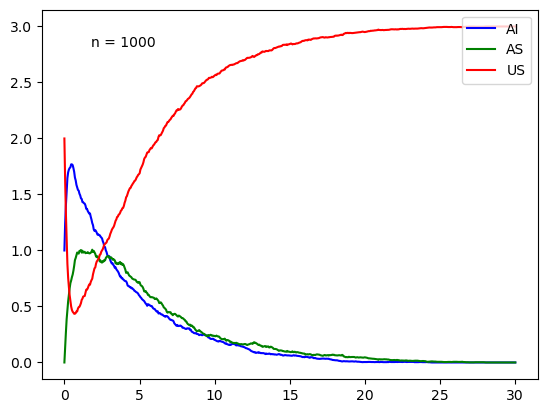

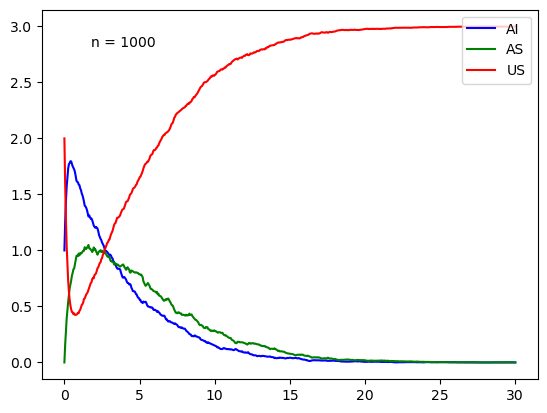

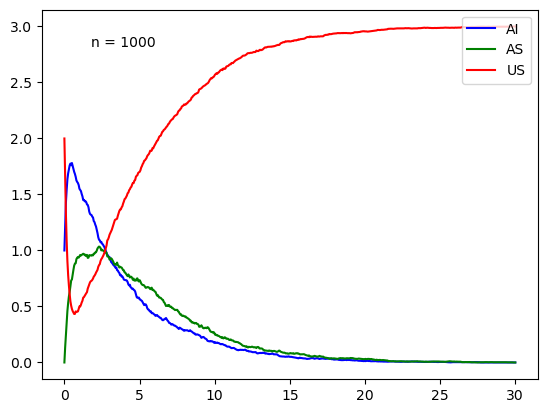

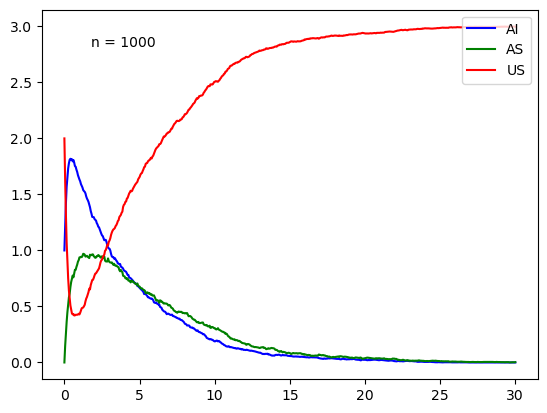

In [62]:
from out import Mln_dynamics
from out import run_sim
model = Mln_dynamics()
run_sim(model)

In [61]:
from out_gillespie import Mln_dynamics as ml
from out_gillespie import run_sim as rs
model = ml()
rs(model)